In [1]:
%%html 
<style>code,kbd,pre,samp,.Codemirror{font-family: Menlo, Monaco, Consolas, monospace !important}</style>

In [2]:
from itertools import product
from PIL import Image, ImageOps

import numpy as np, pandas as pd, tensorflow as tf
sess = tf.InteractiveSession()

import matplotlib, seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline
sns.set_style('whitegrid')
matplotlib.rcParams.update({
    'figure.figsize': (10, 6), 'font.size': 16, 'axes.labelsize': 20, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'font.family': 'Helvetica,Arial,sans-serif'
})
%config InlineBackend.figure_format = 'retina'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Machine Learning lab 7: convolutional neural networks
## Jake Rowland and Paul Herz
2017-11-20

> **Nota bene:** much of this introductory text that describes the classification task and dataset preparation is replicated from a previous project using the same dataset, so as to avoid unnecessary rewriting. Some of it is partially replicated but modified to reflect necessary differences, whereas others are wholly reproduced.

## 1. Introduction

From Lab 3:
> We sought a dataset with clear and unambiguous classes (pre-labelled). However, to avoid a classification task that was overly-ambitious, a small number of classes was ideal. We settled upon a labelled image dataset containing cats and dogs ([Kaggle](https://www.kaggle.com/c/dogs-vs-cats)).

In the [previous project](https://github.com/SMU-ML-2017/Project3/blob/master/Project3%20ML.ipynb) using this dataset, we never performed a classification task, instead only theorizing about such a task. We only analyzed performance of different Principal component analysis (PCA) methodologies and DAISY feature extraction. It took about 125 principal components to reach 90% cumulative explained variance, and our intra-class feature distance visualizations were difficult to make meaning of.

If we gained something of great use from that project, it was a better understanding of image processing. Since then, we have worked with the rudiments of neural networks, and have had several successful attempts at building passable and easy-to-understand neural networks on top of Keras (Tensorflow backend). In this lab, we will develop a Convolutional Neural Network (CNN) using Keras, and evaluate its performance on the task of visually classifying dogs vs. cats.

### 1.1 Background

*Wholly reproduced from Lab 3*

> Elson, Jeremy, John Douceur, Jon Howell, and Jared Saul. "Asirra." *Proceedings of the 14th ACM conference on Computer and communications security - CCS 07*, 2007. doi:10.1145/1315245.1315291 ([Libre PDF](https://www.microsoft.com/en-us/research/wp-content/uploads/2007/10/CCS2007.pdf)).

This dataset was furnished by Asirra (Animal Species Image Recognition for Restricting Access). Asirra is a CAPTCHA security challenge, i.e. a program designed to bar automated processes from accessing a system by forcing the user to prove their humanity. Asirra was an experiment in making a new and unique type of CAPTCHA, that would be trivial, less frustrating, and endearing to users.

Asirra pulls images of pets from Petfinder, an adoption service. These images are restricted to cats and dogs. Petfinder users have self-labeled these postings as cats or dogs during the upload process. Asirra challenges the user to identify a set of 12 images as either cats or dogs to proceed, and advertises an "Adopt me" button as a quid pro quo for using Petfinder's content.

According to the abstract:
> [Asirra] can be solved by humans 99.6% of the time in under 30 seconds, ... Barring a major advance in machine vision, we expect computers will have no better than a 1/54,000 chance of solving it.

Bear in mind that this was published in 2007. The one in 54,000 figure is an extremely pessimistic estimate, perhaps even a faulty one, as it is an ~8% piece of the probability of guessing randomly on a series of 12 binary choices ($0.5^{12} = 1/4096$). So perhaps even for the time of its writing the figure is extreme, but even the figure for guessing randomly is poor (~0.02%).

There is little doubt that such a statement was interpreted as a challenge to the machine learning community, one that Kaggle worked with the Asirra (Microsoft Research) team to formalize in 2013. Asirra forwarded their dataset to Kaggle, and the "Dogs vs. Cats" challenge has been open ever since. According to Kaggle, classifying cats against dogs in this dataset is nontrivial due to the complexity and heterogeneity of the images:

> There is enormous diversity in the photo database (a wide variety of backgrounds, angles, poses, lighting, etc.), making accurate automatic classification difficult

In summary: whereas the original authors posited the success rate could not exceed 1:54000 with the contemporary state-of-the-art (SoA), the more realistic random choice success probability is 1:4096; an outdated poll states that the SoA per-image accuracy was 60% (1:459 success rate); the contemporary SoA for per-image accuracy is 80% (Golle, 2009), equating to a roughly 1:15 success rate (figures from Kaggle and Microsoft Research).

> Golle, P. (2009). Machine learning attacks against the Asirra CAPTCHA. *Proceedings of the 5th Symposium on Usable Privacy and Security - SOUPS 09*. doi:10.1145/1572532.1572585 ([Libre PDF](http://xenon.stanford.edu/~pgolle/papers/dogcat.pdf))

The purpose and worth of this dataset originated as a novel experiment in security controls and automation defeat mechanisms. However, it has become a relatively popular dataset, as well as a barometer of the SoA in image recognition and classification — it stands as a continual challenge to the ML community to further the SoA vis-à-vis this dataset's primary classification task.

### 1.2 Business Case

*Wholly reproduced from Lab 3*

Classifying cats against dogs may not appear to have a business case per se. The academic endeavor that the dataset represents (*vide supra*, as a "barometer") is insufficient too as a viable case. To the original source of this data, Petfinder, there may be minor value to the service in this classification task. Petfinder's user-uploaded postings of adoptable animals are already hand-labeled during the upload process, but there may be a marketable, if not value-adding, "wow" factor to the service being able to automatically classify an animal based on the uploaded photo.

Another more slightly practical business case of this classification to Petfinder specifically would be the ability to integrate said capability into their moderation tools. This is a similar argument to the one we proposed for fraud and spam detection in Amazon comments in a prior assignment — finding discrepancies between the user-provided data and the classification tool as a piece in the pipeline of user content moderation. Any site on the order of size of Petfinder is sure to have staff and resources dedicated to moderation, and it would reduce expense (read "add value") to their moderation workflow if more probably mislabeled or misleading content was floated to the top of moderator's queues for review. The reduction of such incorrect content would "clean up" the site to an extent — user content is inherently chaotic but users want to see clean, well-formatted content. Chiefly, for an algorithm to be able to discern between cats, dogs, and potentially a third, null category, Petfinder could see postings where the user-labeled pet type did not match the photo, and perhaps more quickly regulate postings where there was no animal present in the photo.

We see this second case as being a more viable integration into the business of Petfinder specifically, or animal adoption/listing sites more generally. Provided that the dataset is from Petfinder, and therefore best represents the content *of* Petfinder, we chose to mention the case specifically relative to them. The second business case truly adds value and efficiency to Petfinder's content management, which directly affects the perceived quality of the site.

### 1.3 Serviceability

In recent years, social media platforms specifically and user-content sites more generally have been abused by malicious parties as platforms for illegal commerce or content. In August, 2018, Sen. Rob Portman (R-OH) introduced the [Stop Enabling Sex Traffickers Act of 2017](https://www.congress.gov/bill/115th-congress/senate-bill/1693/text), a bill with an uncontroversial title that controversially holds online services accountable for the content their users post, full stop. The bill has been called vague and can be read widely to encompass all matter of content, not just content pertaining to trafficking. Even if this bill does not become law, it portends a legislative trend toward increasing the liability of online service owners.

Moderation is already a massive task for which larger companies have to hire/contract/outsource thousands of people, and services like Google and Facebook already have machine learning components in their moderation pipeline, not to the exclusion of human eyes. The legal liability and the cost of work to moderate nation or world-scale user-submitted data on a popular website is simply becoming too massive. As such, even a presumably uncorruptable site like Petfinder is susceptible to these legal and financial pressures.

`EXPLAIN`


## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

```
CHANGE THIS
```

We will load the dataset and modify it outright for the sake of computational efficiency. This forgoes the usual preliminary superficial analysis, which will follow after this step. The original dataset is large (25,000 images, 572MB) when compared to the minimal requirements of this assignment (≥1000 images), and can be downscaled (≥20px squared), as well as stripped of color.

First, we establish a standard size to which all images will be resized. This is a prerequisite for making the results of later operations (dimensionality reduction, feature extraction) meaningful, that is, comparing apples to apples.


In [3]:
# Parameters controlling the entire experiment
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

image_size = (50, 50) # Size for all images
flip_images = True    # Double the dataset by mirroring it?
dataset_sample = None # How much of the dataset do we want? (None = don't subsample)

evaluation_function = roc_auc_score

In [4]:
import os.path
import random

def generate_dataset_archive(overwrite=False):
    '''
    load all images data/cat.{i}.jpg and data/dog.{i}.jpg
    for i in 0...12499 inclusive, then downscale to
    image_size and archive as a compressed .npz file.
    
    expects you to have extracted the dogs vs. cats
    dataset from kaggle into a folder underneath this
    notebook called data. it consists of 25000 JPEG images.
    '''    
    archive_name = 'dogs_vs_cats.npz'
    file_prefix = 'data/'
    PIL_GRAYSCALE_MODE = 'L'
    images = []
    labels = []
    images_per_class = 12500
    
    archive_exists = os.path.isfile(archive_name)
    if not overwrite and archive_exists:
        print(f'The archive file {archive_name} already exists.\nSkipping data processing.\n')
        return
    elif overwrite and archive_exists:
        print('Processing data and overwriting to archive file...')
    else:
        print('Processing data and creating new archive file...')
        
    print(f'Loading {images_per_class*2} images and compressing to size {image_size}')
    
    for pet_type, index in product(['cat','dog'], range(images_per_class)):
        file_name = f'{pet_type}.{index}'
        image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=PIL_GRAYSCALE_MODE)
        image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
        data = np.array(image.getdata())
        
        is_dog = (pet_type == 'dog')
        images.append(data)
        labels.append(is_dog)
    
    # numpy archive (.npz) of multiple objects
    np.savez_compressed(
        archive_name, 
        data=np.array(images,dtype=np.uint8), 
        target=np.array(labels,dtype=np.bool_)
    )
    print('Saved.')
    print()

## numpy method (slow, CPU bound)
# def normalize_scalar(x):
#     return 2*((x/255)-0.5)
# normalize = np.vectorize(normalize_scalar, otypes=[np.float32])
# def normalize(data):
#     print('Mapping int8 data [0,255] to float32 [-1,1]\n')
#     _normalize_scalar=lambda x:2*((x/255)-0.5)
#     _normalize=np.vectorize(_normalize_scalar,otypes=[np.float32])
#     return np.apply_along_axis(_normalize, 0, data)

# tensorflow (11x faster on GPU)
def normalize(data):
    print('Mapping int8 data [0,255] to float32 [-1,1]\n')
    tensor = tf.convert_to_tensor(data, np.float32)
    tensor = tensor/127.5 - 1
    return tensor.eval()

def flip_bitmap(data):
    data = data.reshape(image_size)
    data = np.fliplr(data)
    return data.flatten()
flip_all_images = np.vectorize(flip_bitmap, otypes=[np.float32])
    
def flip_dataset(data,target):
    data_flipped = np.copy(data)
    data_flipped = np.apply_along_axis(flip_bitmap, 1, data_flipped)
    return np.vstack((data,data_flipped)), np.concatenate((target,target))

def load_dataset_archive(sample=None, flip=False):
    '''
    pick a random sample from the total population of images.
    create horizontally mirrored duplicates of all source images
    if requested.
    '''
    archive_name = 'dogs_vs_cats.npz'
    ds = np.load(archive_name)
    
    image_count = ds["data"].shape[0]
    sample_count = image_count
    print(f'Loaded archive with a total of {image_count} images.')
    
    if sample is None:
        print(f'No sampling - using full dataset ({image_count} images)')
        data = ds['data']
        target = ds['target']
    elif 0.0 > sample < 1.0:
        raise ValueError('Sample rate must be between 0 and 1')
    elif sample is not None:
        sample_count = int(sample * image_count)
        if sample_count == 0:
            raise ValueError(f'A sample rate of {sample} yields a zero-sized sample!')
        print(f'Randomly sampling {sample*100}% of the dataset ({sample_count}/{image_count})')
        sample = random.sample(range(image_count), sample_count)
        data = ds['data'][sample]
        target = ds['target'][sample]
        
    if flip: 
        print(f'Flipping to double dataset ({sample_count*2} images)')
        data, target = flip_dataset(data, target)
    print()
    return data, target

In [5]:
# Loading the whole dataset from individual image files
# (25,000 images total) is very slow. This function
# generates a numpy archive (.npz) of the downsized grayscale
# images if it doesn't already exist. This saves time when
# rerunning the notebook.
%time generate_dataset_archive()

The archive file dogs_vs_cats.npz already exists.
Skipping data processing.

CPU times: user 214 µs, sys: 98 µs, total: 312 µs
Wall time: 216 µs


In [6]:
print('LOADING + EXPANSION\n','—'*50,sep='')
%time data_raw, target = load_dataset_archive(sample=dataset_sample, flip=flip_images)

print('\nNORMALIZATION\n','—'*50,sep='')
%time data = normalize(data_raw)

print('\nimages stored as dtype',data.dtype)
print(len(data),'images,',image_size,'pixels each')

if data[0].shape[0] != image_size[0]*image_size[1]:
    print('WARNING: the loaded/generated data is a different size than defined')
    print('by `image_size`.')

mem = data.nbytes
print('RAM usage:',mem/1000000.,'MB')

LOADING + EXPANSION
——————————————————————————————————————————————————
Loaded archive with a total of 25000 images.
No sampling - using full dataset (25000 images)
Flipping to double dataset (50000 images)

CPU times: user 693 ms, sys: 105 ms, total: 798 ms
Wall time: 791 ms

NORMALIZATION
——————————————————————————————————————————————————
Mapping int8 data [0,255] to float32 [-1,1]

CPU times: user 1.66 s, sys: 1.33 s, total: 2.99 s
Wall time: 2.07 s

images stored as dtype float32
50000 images, (50, 50) pixels each
RAM usage: 500.0 MB


In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

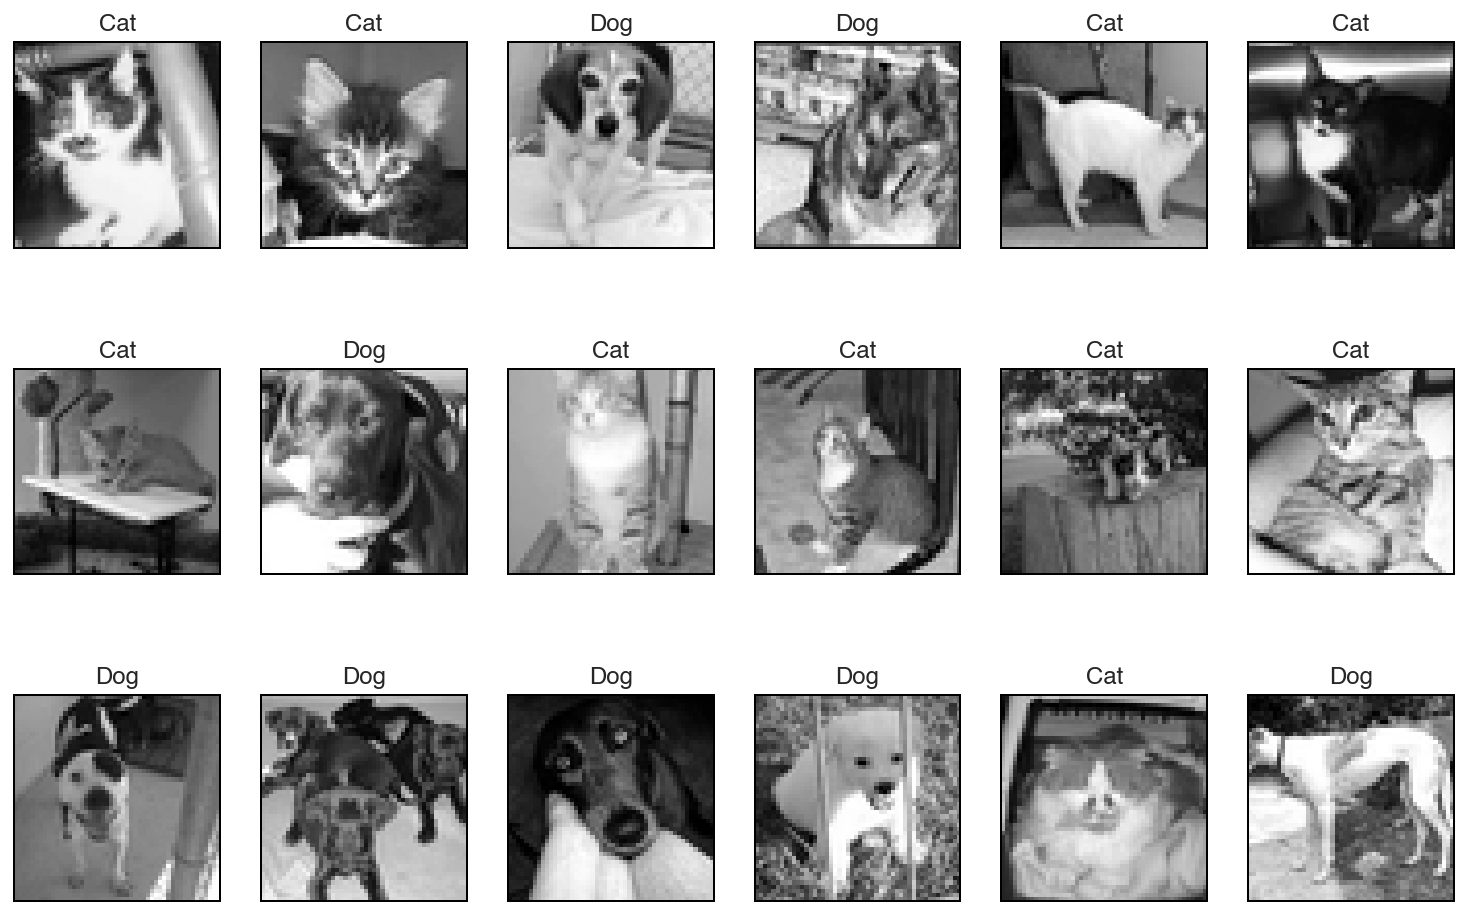

In [8]:
idx = np.random.choice(data_raw.shape[0], 18, replace=False)
some_images = data_raw[idx]
some_labels = np.vectorize(lambda x: 'Dog' if x else 'Cat')(target[idx])
plot_gallery(some_images, some_labels, image_size)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Dense, BatchNormalization,\
Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import Callback
from tqdm import tqdm

try:
    from IPython.core.display import clear_output
    is_ipython = True
except ImportError:
    clear_output = lambda *args: None
    is_ipython = False

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters,
        dense_sizes,
        output_size,
        
        batch_normalize = True,

        layer_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2,
        epoch_callback=None
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.dense_sizes = dense_sizes
        self.output_size = output_size
        
        self.batch_normalize = batch_normalize
        
        self.layer_activation = layer_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self.epoch_callback = epoch_callback
        
        self._make_model()
    
    def _make_convolution_layers(self):
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for filters in self.n_filters:
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=filters,
                    kernel_size=(3,3),
                    padding='same',
                    activation=self.layer_activation
                )
            )
            # Add batch normalization to the convolution layer
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=(2,2), data_format='channels_first')
            )
        
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.layer_activation)
            )
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
        self._model.add(
            Dense(self.output_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        
        self._make_convolution_layers()
        self._make_dense_layers()
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        progress_bar = None
        if self.verbose == 3:
            progress_bar = tqdm(total=self.epochs)
        
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
                if net.verbose == 3:
                    clear_output()
                    progress_bar.update(1)
                if net.epoch_callback is not None:
                    net.epoch_callback(epoch)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose if self.verbose != 3 else 0,
           callbacks=[AnalyticsCallback()]
        )
        if self.verbose == 3:
            progress_bar.close()
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [10]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.

from tqdm import tqdm

try:
    from IPython.core.display import clear_output
except ImportError:
    pass
    
class CrossValidation:
    def __init__(self, cv, verbose=False):
        self.cv = cv
        self.verbose = verbose
        self.progress = None

    def run(self, ModelClass, parameters, data, target):
        cv_indices = self.cv.split(data, target)
        scores = np.empty(n_splits)
        nets = [None]*n_splits

        if 'epochs' in parameters:
            total_epochs = n_splits*parameters['epochs']
#             print(
#                 f'Performing {n_splits}-fold Stratified CV\nat {parameters["epochs"]} '
#                 f'epochs each ({total_epochs} epochs total)'
#             )
        if self.verbose:
            self.progress = tqdm(range(total_epochs),ncols=70,unit='epoch')
        for i,indices in enumerate(cv_indices):
            scores[i],nets[i] = self._step(ModelClass, parameters, indices, data, target)
        return scores,nets
    
    def _step(self, ModelClass, parameters, indices, data, target): 
        train_index, test_index = indices
        X_train = data[train_index]
        y_train = np.asarray(pd.get_dummies(target[train_index]))
        X_test = data[test_index]
        y_test = target[test_index]
    
        up = self._update_progress
        def make_epoch_handle():
            def epoch_handle(epoch):
                up()
            return epoch_handle

        if 'epoch_callback' in parameters and self.progress is not None:
            parameters['epoch_callback'] = make_epoch_handle()

        # training
        clf = ModelClass(**parameters)
        clf.fit(X_train, y_train)

        # testing
        y_hat_raw = clf.predict(X_test)
        y_hat = ModelClass.one_hot_output(y_hat_raw)
        score = evaluation_function(pd.get_dummies(y_test), y_hat)
        return score,clf
    
    def _clear(self):
        try:
            clear_output(wait=True)
        except AttributeError:
            pass
    
    def _update_progress(self):
        self._clear()
        self.progress.update(1)
    
    @staticmethod
    def get_logs_from_nets(nets, parameter_name):
        return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

In [151]:
def graph_cv_compare(score_sets, names=range(10), colors=None):
    ax = plt.gca()
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_folds = len(score_sets[0])
    n_items = len(score_sets)
    x = np.arange(n_folds)
    width = 1/(n_items+1)
    offset = width*0.5*(n_items+1)
    space = np.linspace(-1, 1, n_items+2)[1:-1]
    for index in range(n_items):
        x_offset = x + space[index]*offset
        plt.bar(x_offset,score_sets[index], width=width, label=names[index], color=colors[index])
    plt.xticks(range(n_folds),range(1,n_folds+1))
    plt.title(f'Stratified {n_folds}-fold cross validation')
    plt.xlabel('fold #')
    plt.ylabel('score')
    plt.ylim(0,1)
    plt.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
    print('\n','='*50,'\nAccuracy (ROC)\n',sep='')
    for index in range(n_items):
        print(f'{names[index]}: {np.asarray(score_sets[index]).mean():0.2} '
              f'(±%{np.asarray(score_sets[index]).std() * 2:0.2})')
    print('='*50,'\n')
# https://gist.github.com/phrz/98045738d182dd75d1eed74470b9b2ef
def average_line(data, plot_quartiles=True, color='#016d91'):
    '''
    Given 2D data where columns are samples and rows are classes/time series, 
    plot an average line and surrounding quartile area 
    (like a continuous box plot)
    '''
    averages = np.average(data,axis=0)
    x = np.arange(1, len(averages)+1)
    plt.plot(x, averages, color=color)

    if plot_quartiles:
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
        plt.fill_between(x, lower, upper, color=color, alpha='0.25', linewidth=0)

In [12]:
n_splits = 10
skfold = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)
cv = CrossValidation(skfold, verbose=True)

# CNN 1 Comparison

In [11]:
params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,256,256],
    dense_sizes=[128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=0,
    epoch_callback=None # do not remove
)

In [13]:
import os.path
archive_name = 'cv_result_50k_50_50_10f_roc.npz'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    scores, nets = cv.run(ConvolutionalNeuralNet, params, data, target)
    accs = CrossValidation.get_logs_from_nets(nets, 'binary_accuracy')
    np.savez(archive_name, scores=scores, accs=accs)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    ds = np.load(archive_name)
    scores, accs = ds['scores'], ds['accs']

Archived results found on disk. Reloading.
(to perform CV from scratch, delete cv_result_50k_50_50_10f_roc.npz)


# CNN 2 Comparison

In [24]:
cnn2_params = dict(
    input_shape=image_size,

    n_filters=[32,64,64,128],
    dense_sizes=[128,128,128,128],

    output_size=2,

    loss='binary_crossentropy', 
    optimizer='Nadam', 
    metrics=['binary_accuracy'],

    batch_size=32,
    epochs=40,
    shuffle=True,
    verbose=0,
    epoch_callback=None # do not remove
)

In [25]:
import os.path
archive_name = 'cnn2_cv_result_50k_50_50_10f_roc.npz'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    cnn2_scores, cnn2_nets = cv.run(ConvolutionalNeuralNet, cnn2_params, data, target)
    cnn2_accs = CrossValidation.get_logs_from_nets(cnn2_nets, 'binary_accuracy')
    np.savez(archive_name, scores=cnn2_scores, accs=cnn2_accs)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    ds = np.load(archive_name)
    cnn2_scores, cnn2_accs = ds['scores'], ds['accs']

100%|██████████████████████████| 400/400 [1:20:24<00:00, 12.17s/epoch]

# MLP Comparison

In [17]:
%%time

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import os.path

archive_name = 'mlp_cv_result_50k_50_50_10f_roc.npy'
archive_exists = os.path.isfile(archive_name)

if not archive_exists:
    print('Results could not be loaded. Performing CV from scratch.')
    clf = MLPClassifier(hidden_layer_sizes=(128,128,128),verbose=False)
    mlp_scores = cross_val_score(clf, data, target, cv=n_splits, scoring='roc_auc', verbose=0)
    np.save(archive_name, mlp_scores)
else:
    print('Archived results found on disk. Reloading.')
    print(f'(to perform CV from scratch, delete {archive_name})')
    mlp_scores = np.load(archive_name)
print()

Results could not be loaded. Performing CV from scratch.

CPU times: user 57min 10s, sys: 1h 13min 58s, total: 2h 11min 9s
Wall time: 17min 3s


# Results

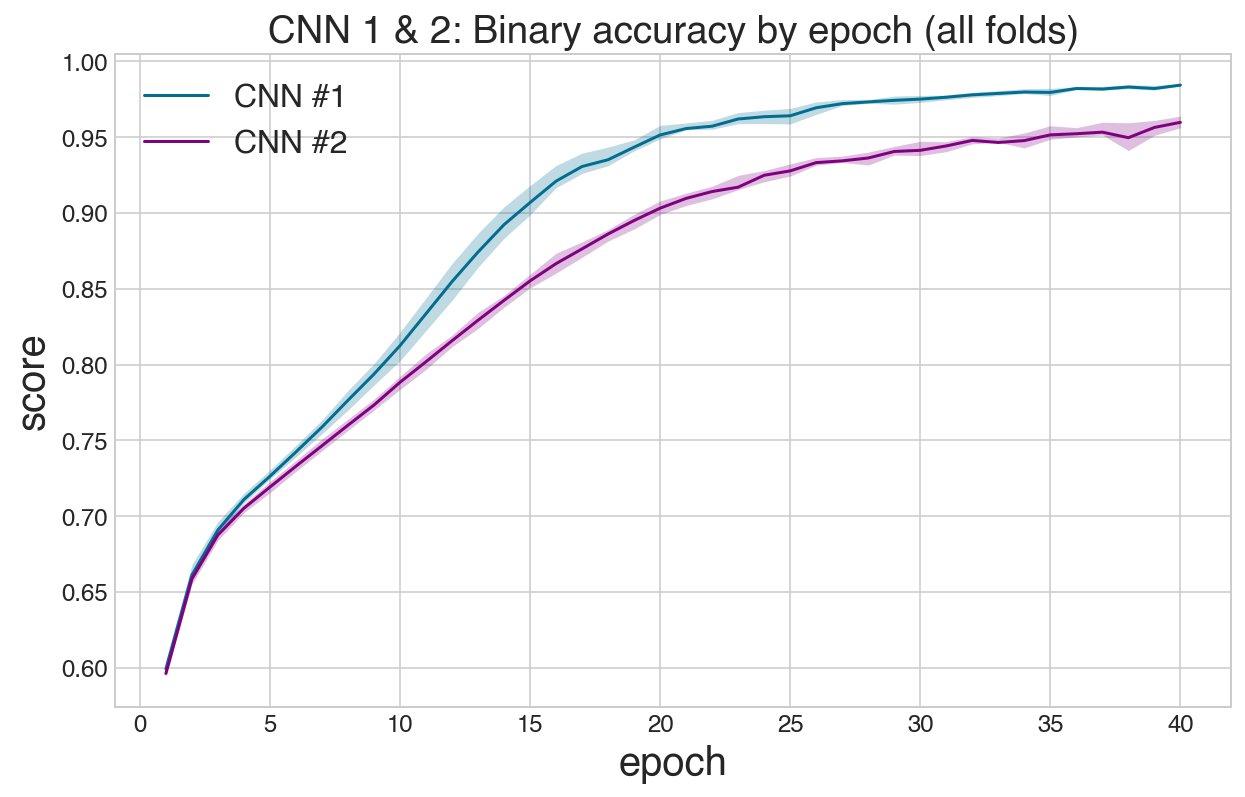

In [153]:
average_line(accs)
average_line(cnn2_accs, color='purple')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(labels=['CNN #1','CNN #2'])
plt.title('CNN 1 & 2: Binary accuracy by epoch (all folds)');


Accuracy (ROC)

CNN #1: 0.97 (±%0.014)
CNN #2: 0.92 (±%0.037)
MLP: 0.7 (±%0.017)



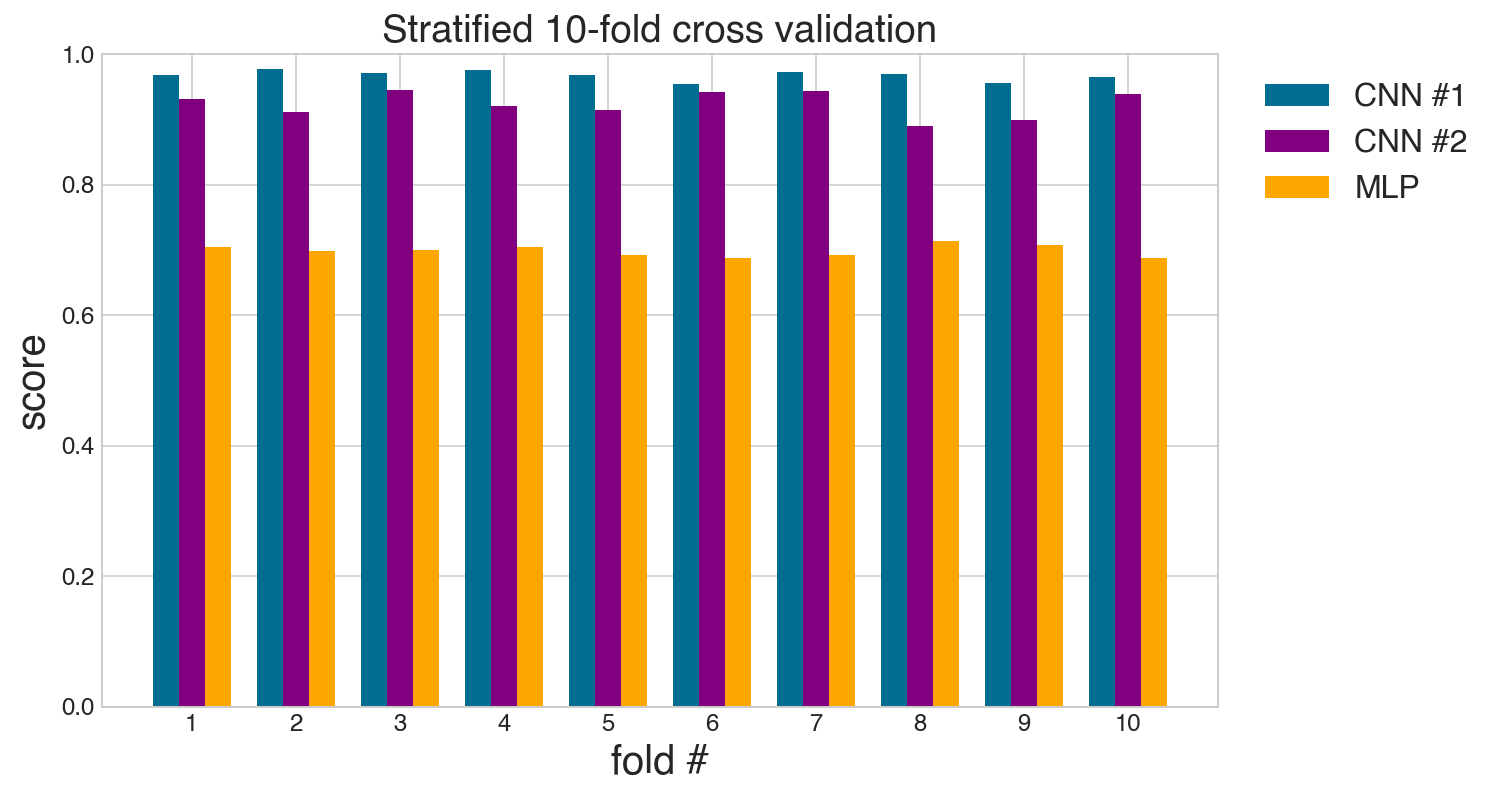

In [152]:
graph_cv_compare([scores, cnn2_scores, mlp_scores], 
    names=['CNN #1', 'CNN #2', 'MLP'], 
    colors=['#016d91', 'purple', 'orange']
)

In [ ]:
sess.close()